<a href="https://colab.research.google.com/github/noahtf13/wf-vs-cb/blob/main/WF_vs_CB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 63 kB/s 
     |████████████████████████████████| 198 kB 70.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=9bfb7e94cc98af88cb97ea12a3c5f05e9e62de07b1f365a877a10f1aa311a30a
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [2]:
!pip install h3
!pip install geopandas
!pip install h3pandas
!pip install shapely
!pip install geopy
!pip install requests-html
!pip install nest_asyncio
!pip install geojson

     |████████████████████████████████| 793 kB 7.6 MB/s 
     |████████████████████████████████| 994 kB 6.5 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.3 MB 14.3 MB/s 
     |████████████████████████████████| 73 kB 1.6 MB/s 
  Created wheel for h3pandas: filename=h3pandas-0.2.2-py3-none-any.whl size=17058 sha256=fea59a819cccc6c43306c8c116e24ab054df4ad09e029d2005bacbc3e3c29ec3
  Stored in directory: /root/.cache/pip/wheels/f9/be/d1/257bdc23c924093aa650a00f74dbb69482d08983b1e33209df
Successfully built h3pandas
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 103 kB 58.6 MB/s 
     |████████████████████████████████| 138 kB 70.6 MB/s 
     |████████████████████████████████| 127 kB 78.4 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=13a72f2aaf577085cdf0dbfe967746f8f386ae86b0a3d1e3bedc3b21c70d6ff3
  Stored in directory: /root/

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [ ]:
import h3
import h3pandas
import geopandas as gpd
import json
import pandas as pd   
import requests
from pyspark.sql.functions import array, avg, col, count, countDistinct, collect_set, desc, dense_rank, \
                                  explode, expr, first, length, lit, log, min as fmin, \
                                  max as fmax, \
                                  regexp_replace, substring, sum as fsum, \
                                  when, udf, rank, row_number, round as fround, floor
from pyspark.sql.types import ArrayType, StringType, StructType
from shapely.geometry import shape, mapping, Polygon
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from requests_html import HTMLSession, AsyncHTMLSession
from tqdm import tqdm
import numpy as np
import nest_asyncio
import seaborn as sns
from pyspark.sql.window import Window
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import geojson

First we need to get presidential results, you may have seen extremely detailed maps like [this one from the NY Times](https://www.nytimes.com/interactive/2021/upshot/2020-election-map.html) where results are still being collected at the precint level and are missing 11% of votes cast. So currently it seems as if there is not a accessabile (API, .csv, etc) source for precint-level data but I did find awesome work from the [MIT Election Lab](https://electionlab.mit.edu/data) which contains a very nicely formatted set of county-level results from the 2020 election.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df1 = (
  spark
  .read
  .format("csv")
  .option('header', True)
  .load("/content/drive/MyDrive/Hobby DS/cb_wf/countypres_2000_2020.csv")
)

We dropped all other party votes and simply calculated the percent of all two-party votes that were Democratic. I used a random number generator to determine if I would take the % Democratic vs % Republican.

In [ ]:
part_lean = (
    df1
    .where(col('party').isin(['DEMOCRAT', 'REPUBLICAN']) & (col('year') == 2020))
    .groupby('state', 'county_name', 'county_fips')
    .pivot('party')
    .agg(first('candidatevotes'))
    .withColumn('total_two_pty_votes', col('REPUBLICAN') + col('DEMOCRAT'))
    .withColumn('dem_pct', col('DEMOCRAT')/col('total_two_pty_votes'))
)

In [ ]:
(
    part_lean
    .where(col('county_name') == "BUNCOMBE")
    .toPandas()
)

,state,county_name,county_fips,DEMOCRAT,REPUBLICAN,total_two_pty_votes,dem_pct
0,NORTH CAROLINA,BUNCOMBE,37021,29257,6159,35416.0,0.826096


Now we have county data but how do we geographically represent these counties? Where is Autaga County in Alabama? Luckily [this Wikipedia page](https://en.wikipedia.org/wiki/User:Michael_J/County_table) has county FIPS (standard way to indentify a county) with their centroid (center) coordinates and of course there is a tool to easily get a .csv from it [here](https://wikitable2csv.ggor.de/). No need to scrape with Selenium, Beautiful Soup, or look at the network data of the site if we don't have to!

In [ ]:
county_info = spark.read.format("csv").option('header', True).load("/content/drive/MyDrive/county_info.csv")

In [ ]:
(
    county_info
    .where(col('fips') == 37021)
    .toPandas()
)

,Sort [1],State,FIPS,County [2],County Seat(s) [3],Population(2010),Land Areakm²,Land Areami²,Water Areakm²,Water Areami²,Total Areakm²,Total Areami²,Latitude,Longitude
0,1901,NC,37021,Buncombe,Asheville,"238,318","1,700.773",656.672,8.985,3.469,"1,709.757",660.141,+35.609371°,–82.530426°


In [ ]:
county_coordinates = (
    county_info
    .select(
        'FIPS',
        'Latitude',
        'Longitude'
    )
    .withColumn('lat_neg', when(col('Latitude').contains('–'),-1).otherwise(1))
    .withColumn('long_neg', when(col('Longitude').contains('–'),-1).otherwise(1))
    .withColumn(
        'Latitude',
        regexp_replace('Latitude', '[–+°]', '')
        .astype('float') * col('lat_neg')
    )
    .withColumn(
        'Longitude',
        regexp_replace('Longitude', '[–+°]', '')
        .astype('float') * col('long_neg')
    )
    .drop('lat_neg', 'long_neg')
)

In [ ]:
county_votes_coordinates = (
    part_lean
    .join(
        county_coordinates,
        part_lean['county_fips'] == county_coordinates['FIPS'],
        'left'
    )
)

In [ ]:
county_votes_coordinates.printSchema()

root
 |-- state: string (nullable = true)
 |-- county_name: string (nullable = true)
 |-- county_fips: string (nullable = true)
 |-- DEMOCRAT: string (nullable = true)
 |-- REPUBLICAN: string (nullable = true)
 |-- total_two_pty_votes: double (nullable = true)
 |-- dem_pct: double (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)



In [ ]:
(
    county_votes_coordinates
    .where(col('FIPS') == 37021)
    .toPandas()
)

,state,county_name,county_fips,DEMOCRAT,REPUBLICAN,total_two_pty_votes,dem_pct,FIPS,Latitude,Longitude
0,NORTH CAROLINA,BUNCOMBE,37021,29257,6159,35416.0,0.826096,37021,35.609371,-82.530426


Great so we have cleaned and joined the coordinates of the centers of the counties to their election results. In a V2 of this iteration it might be nice to spread out the votes between a larger number of coordinates within the county boundaries, this is because our analysis is assuming that all votes of a county happened in the center of it, it is a nice approximation but obviously not fully representative of where votes actually occur.

In [ ]:
missing_votes = (
    county_votes_coordinates
    .where(col('Latitude').isNull())
    .agg(fsum('total_two_pty_votes'))
    .rdd.flatMap(lambda x: x).collect()[0]
)

total_votes =  (
    county_votes_coordinates
    .agg(fsum('total_two_pty_votes'))
    .rdd.flatMap(lambda x: x).collect()[0]
)

missing_votes/total_votes

0.005826961390169829

Some counties were not associated with coordinates but it only resulted in 0.5% of votes missing, so it isn't a priority at the moment to fix that at the moment.

In [ ]:
county_votes_coordinates.count()

3155

US has 10M sq KM. Chose a relevant H3 Hex

In [ ]:
@udf(returnType=StringType())
def geo_h3(lat, long, resolution):
    if long is not None:
        return h3.geo_to_h3(lat, long, resolution)


In [ ]:

county_h3 = (
    county_votes_coordinates
    .withColumn('h3_5', geo_h3(col('Latitude'), col('Longitude'), lit(5))) # Biggest resolution where each county is still in its own bucket
)

In [ ]:
(
    county_h3
    .select('h3_5', 'dem_pct', 'total_two_pty_votes')
    .toPandas()
    .to_csv('unsmoothed.csv')
)

So what about those hexagon things we were talking about? Well they have what is called a precision, higher values of precision mean smaller hexagons. Just as a rule of thumb I wanted a precision where each county didn't have to share a hex. This resulted in an h3 of 7.

In [ ]:
with open('/content/drive/MyDrive/USA_geo-1.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

In [ ]:
def fill_out_geojson_h3(json_obj, precision): 
    g = [x.buffer(0) for x in shape(json_obj['features'][0]['geometry']).buffer(0).geoms]
    hex_list = []
    for polygon in g:
        # Convert Polygon to GeoJSON dictionary
        poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
        # Parse out geometry key from GeoJSON dictionary
        poly_geojson = poly_geojson['features'][0]['geometry'] 
        # Fill the dictionary with Resolution 10 H3 Hexagons
        h3_hexes = h3.polyfill(poly_geojson, precision, geo_json_conformant = True)
        hex_list = hex_list + list(h3_hexes)
    return hex_list

In [ ]:
hex_list = fill_out_geojson_h3(obj, 5)

In [ ]:
us_h3 = (
    spark.createDataFrame(hex_list, StringType())
    .withColumnRenamed('value', 'h3')
)

In [ ]:
us_h3.count()

37013

# Get Cracker Barrel and Whole Foods Locations

## Whole Foods

In [ ]:
hex_list_3 = fill_out_geojson_h3(obj, 3)

NameError: ignored

In [ ]:
len(hex_list_3)

NameError: ignored

In [ ]:
h3_3_coordinates = []
for hexagon in hex_list_3:
    h3_3_coordinates.append(list(h3.h3_to_geo(hexagon)))

In [ ]:
get_tomtom_locations(geo_json, h3_precision)

In [ ]:
wf_locations = []
for location in tqdm(h3_3_coordinates):
    resp = requests.get(
        'https://api.tomtom.com/search/2/search/whole%20foods%20market.json?'
        f'typeahead=false&limit=100&lat={location[0]}&lon={location[1]}&radius=10000000&key=luoXzrbCbutnxhLjGnSGC1AHCCnZvzDl'
    )
    data = json.loads(resp.text)
    for result in data['results']:
        name = result['poi']['name']
        location = result['position']
        wf_locations.append([name, location['lat'], location['lon']])

In [ ]:
wf_locations = spark.createDataFrame(wf_locations).toDF(*['name', 'lat', 'lon'])

In [ ]:
actual_wf = (
    wf_locations
    .where(col('name') == 'Whole Foods Market')
    .dropDuplicates()
)

In [ ]:
actual_wf.count()

In [ ]:
actual_wf.toPandas().head()

In [ ]:
actual_wf_h3 = (
    actual_wf
    .withColumn(
        'h3',
        geo_h3(actual_wf['lat'], actual_wf['lon'], lit(5))
    )
    .toDF(*['name', 'wf_lat', 'wf_lon', 'h3_5'])
)

In [ ]:
actual_wf_h3.write.mode('overwrite').parquet('/content/drive/MyDrive/wf_cb_locations/wf_parquet')

NameError: ignored

## Cracker Barrel

In [ ]:
cb_locations = [] # Empty list to f
for location in tqdm(h3_3_coordinates):
    resp = requests.get(
        'https://api.tomtom.com/search/2/search/cracker%20barrel%20old%20country%20store.json?'
        f'typeahead=false&limit=100&lat={location[0]}&lon={location[1]}&radius=10000000&key=luoXzrbCbutnxhLjGnSGC1AHCCnZvzDl'
    )
    data = json.loads(resp.text)
    for result in data['results']:
        name = result['poi']['name']
        location = result['position']
        cb_locations.append([name, location['lat'], location['lon']])

In [ ]:
cb_locations = spark.createDataFrame(cb_locations).toDF(*['name', 'lat', 'lon'])

In [ ]:
actual_cb = (
    cb_locations
    .where(col('name') == 'Cracker Barrel Old Country Store')
    .dropDuplicates()
)

In [ ]:
actual_cb_h3 = (
    actual_cb
    .withColumn(
        'h3',
        geo_h3(actual_cb['lat'], actual_cb['lon'], lit(5))
    )
    .toDF(*['name', 'cb_lat', 'cb_lon', 'h3_5'])
)

In [ ]:
actual_cb_h3.write.mode('overwrite').parquet('/content/drive/MyDrive/wf_cb_locations/cb_parquet')

# Putting it all together

In [ ]:
wf = (
    spark.read.parquet('/content/drive/MyDrive/Hobby DS/wf_cb_locations/wf_parquet')
)

wf = (
    wf
    .withColumn(
        'h3_wf',
        geo_h3(wf['wf_lat'], wf['wf_lon'], lit(5))
    )
)

cb = (
    spark.read.parquet('/content/drive/MyDrive/Hobby DS/wf_cb_locations/cb_parquet')
)

cb = (
    cb
    .withColumn(
        'h3_cb',
        geo_h3(cb['cb_lat'], cb['cb_lon'], lit(5))
    )
)

In [ ]:
from math import radians, cos, sin, asin, sqrt, atan2, pi
from pyspark.sql.types import FloatType

@udf(returnType=FloatType())
def haversine_distance(lat1, lon1, lat2, lon2):

    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    try:
        deg2rad = pi/180.0

        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # haversine formula 
        dlon = (lon2 - lon1) 
        dlat = (lat2 - lat1) 

        a = sin(dlat/2.0)**2.0 + cos(lat1) * cos(lat2) * sin(dlon/2.0)**2.0
        c = 2.0 * asin(sqrt(a))

        #c = 2.0 * atan2(sqrt(a), sqrt(1.0-a))

        r = 6372.8 # Radius of earth in kilometers. Use 3956 for miles #No rounding R = 3959.87433 (miles), 6372.8(km)

        value = c*r
    except:
        value = None

    return value

In [ ]:
@udf(returnType = ArrayType(StringType()))
def h3_kring(h3_hex, k):
    if h3_hex is not None:
        return list(h3.k_ring(h3_hex, k)) + list(h3_hex)

In [ ]:
@udf(returnType = ArrayType(StringType()))
def h3_to_geo(h3_hex):
    if h3_hex is not None:
        return list(h3.h3_to_geo(h3_hex))

In [ ]:
us48_kring = (
    us_h3
    .where(
        h3_to_geo(col('h3')).getItem(0).astype('float').between(24,50) # Continental US
    )
    .withColumn('h3_neighbors',h3_kring(col('h3'),lit(10)))
)

In [ ]:
us48_neighbors = (
    us48_kring
    .withColumn('h3_neighbors', explode('h3_neighbors'))
)

In [ ]:
full_data = (
    us48_neighbors
    .join(
        county_h3,
        us48_neighbors['h3_neighbors'] == county_h3['h3_5'],
        'left'
    )
    .join(
        wf,
        us48_neighbors['h3_neighbors'] == wf['h3_wf'],
        'left'
    )
    .join(
        cb,
        us48_neighbors['h3_neighbors'] == cb['h3_cb'],
        'left'
    )
    .withColumn(
        'h3_lat',
        h3_to_geo(col('h3')).getItem(0).astype('float')
    )
    .withColumn(
        'h3_lon',
        h3_to_geo(col('h3')).getItem(1).astype('float')
    )
)

w = (
    Window
    .partitionBy('h3')
    .orderBy('vote_haversine')
)

full_distance = (
    full_data
    .withColumn(
        'wf_haversine',
        haversine_distance(
            full_data['wf_lat'],
            full_data['wf_lon'],
            full_data['h3_lat'],
            full_data['h3_lon']
        )
    )
    .withColumn(
        'cb_haversine',
        haversine_distance(
            full_data['cb_lat'],
            full_data['cb_lon'],
            full_data['h3_lat'],
            full_data['h3_lon']
        )
    )
    .withColumn(
        'vote_haversine',
        haversine_distance(
            full_data['Latitude'],
            full_data['Longitude'],
            full_data['h3_lat'],
            full_data['h3_lon']
        )
    )
    .fillna(1*10**8, subset=['vote_haversine'])
    .withColumn(
        'vote_rank',
        dense_rank().over(w)
    )
    .withColumn(
        'weighted_dem',
        when(
            col('vote_rank') <= 3, # O
            col('DEMOCRAT') / col('vote_haversine') ** 2
        ).otherwise(0)
    )
    .withColumn(
        'weighted_rep',
        when(
            col('vote_rank') <= 3,
            col('REPUBLICAN') / col('vote_haversine') ** 2
        ).otherwise(0)
    )
)

In [ ]:
dem_pct = (
    full_distance
    .where(
        (col('vote_rank') <= 3)
    )
    .select('h3', 'weighted_dem', 'weighted_rep')
    .groupBy('h3')
    .agg(
        (fsum('weighted_dem') /(fsum('weighted_dem') + fsum('weighted_rep'))).alias('dem_pct')
    )
)

In [ ]:
dem_pct.where(col('h3') == '8544d993fffffff').show()

+---------------+-----------------+
|             h3|          dem_pct|
+---------------+-----------------+
|8544d993fffffff|0.813733065124193|
+---------------+-----------------+



In [ ]:
 h3_lean = (
    full_distance
    .groupBy('h3')
    .agg(
        fmin('wf_haversine').alias('wf'),
        fmin('cb_haversine').alias('cb')
    )
    .join(dem_pct, 'h3')
 )

In [ ]:
h3_lean.where(col('h3') == '8544d993fffffff').show()

+---------------+--------+---------+-----------------+
|             h3|      wf|       cb|          dem_pct|
+---------------+--------+---------+-----------------+
|8544d993fffffff|14.76668|7.0554066|0.813733065124193|
+---------------+--------+---------+-----------------+



In [ ]:
 h3_lean.write.mode('overwrite').parquet('/content/drive/MyDrive/wf_cb_locations/final_results') 

In [ ]:
h3_lean = spark.read.parquet('/content/drive/MyDrive/wf_cb_locations/final_results')

In [ ]:
h3_lean.where(col('h3') == '8544d993fffffff').show()

+---------------+--------+---------+-----------------+
|             h3|      wf|       cb|          dem_pct|
+---------------+--------+---------+-----------------+
|8544d993fffffff|14.76668|7.0554066|0.813733065124193|
+---------------+--------+---------+-----------------+



In [ ]:
map_viz = (
    h3_lean
    .select(
        'h3', 
        col('dem_pct').alias('Democratic Vote Percentage'),
        col('wf').alias('Whole Foods Distance (mi)'),
        col('cb').alias('Cracker Barrel Distance (mi)')
    )
    .toPandas()
)

In [ ]:
max_dist = max(
    h3_lean.select('wf').toPandas()['wf'].max(),
    h3_lean.select('cb').toPandas()['cb'].max()
)

In [ ]:
h3_lean = h3_lean.fillna(max_dist, subset=['wf', 'cb'])

In [ ]:
from pyspark.sql.functions import expr
unpivotExpr = "stack(2, 'Whole Foods', wf, 'Cracker Barrel', cb) as (Store,distance)"
h3_lean_viz = (
    h3_lean
    .select(
        "h3", 
        'dem_pct',
        expr(unpivotExpr)
    )
)


In [ ]:
w =  (
    Window
    .partitionBy('store')
    .orderBy('distance')
    .rangeBetween(-15, 15)
)

h3_lean_viz_smoothed = (
    h3_lean_viz
    .withColumn('dem_pct_smoothed', avg('dem_pct').over(w))
    .withColumn('pct_counties_democratic', avg(fround('dem_pct', 0)).over(w))
    .toPandas()
)

In [ ]:
!pip install Image

     |████████████████████████████████| 7.9 MB 4.1 MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19494 sha256=152a399eb314ba216af76d803daef508b3e5287c4beb4b08658fbff069a1ce0b
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built Image


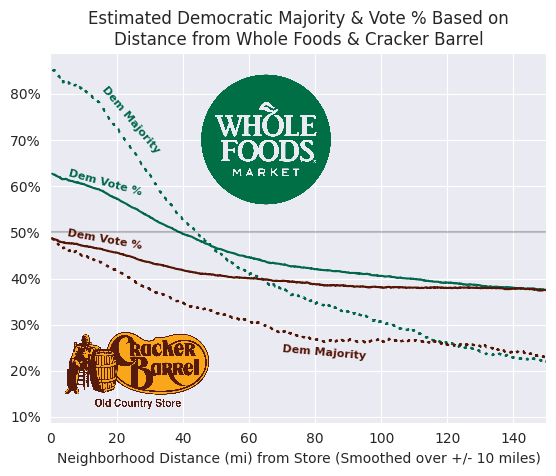

In [ ]:
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.clf()
plt.close()
sns.set_style('darkgrid')


# Wanted palette details
enmax_palette = ['#00674B', '#551505']

g = sns.lineplot(
    x='distance',
    y='pct_counties_democratic',
    hue='Store',
    data=h3_lean_viz_smoothed,
    palette=enmax_palette,
    dashes=[(2,4)],
    style=True
)


g = sns.lineplot(
    x='distance',
    y='dem_pct_smoothed',
    hue='Store',
    data=h3_lean_viz_smoothed,
    palette=enmax_palette
)

g.set(
    xlabel = 'Neighborhood Distance (mi) from Store (Smoothed over +/- 10 miles)',
    title='Estimated Democratic Majority & Vote % Based on\nDistance from Whole Foods & Cracker Barrel',
    ylabel=''
)

g.legend([],[], frameon=False)

g.set(xlim=(0,150))
g.yaxis.set_major_formatter(mtick.PercentFormatter())
vals = g.get_yticks()
g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

logo =image.imread('/content/drive/MyDrive/Hobby DS/cb_wf_assets/wf.png')
imagebox = OffsetImage(logo, zoom=0.07)
ab = AnnotationBbox(imagebox, (65, 0.7), frameon = False)
g.add_artist(ab)

logo_cb =image.imread('/content/drive/MyDrive/Hobby DS/cb_wf_assets/cb.png')
imagebox = OffsetImage(logo_cb, zoom=0.045)
cb = AnnotationBbox(imagebox, (26, 0.20), frameon = False)
g.add_artist(cb)

neigh = 'Dem Majority'
pct_dem = "Dem Vote %"

text_list = [
    [neigh, 15, 0.812, 310, enmax_palette[0]],
    [neigh, 70, 0.25, 355, enmax_palette[1]],
    [pct_dem, 5, 0.63, 345, enmax_palette[0]],
    [pct_dem, 5, 0.50, 350, enmax_palette[1]]
]

for legend in text_list:
    g.text(
        legend[1],
        legend[2],
        legend[0],
        color=legend[4],
        fontweight="bold",
        fontsize=8,
        rotation=legend[3],
        horizontalalignment="left",
        verticalalignment="center_baseline"
    )

g.axhline(.5, alpha=.25, color='black')

# fig = g.get_figure()
# fig.savefig('wf_cb.png', dpi=500, bbox_inches = "tight")

In [ ]:
heatmap = (
    h3_lean
    .fillna(max_dist, subset=['wf', 'cb'])
    .withColumn(
        'wf',
        when(col('wf') >= 150, 150)
        .otherwise(col('wf'))
    )
    .withColumn(
        'cb',
        when(col('cb') >= 150, 150)
        .otherwise(col('cb'))
    )
    .withColumn('wf_group', (fround(col('wf')/25)*25).astype('int'))
    .withColumn('cb_group', (fround(col('cb')/25)*25).astype('int'))
)

lean_heatmap= (
    heatmap
    .groupBy('wf_group')
    .pivot('cb_group')
    .agg(
        avg('dem_pct').alias('dem_pct')
    )
    .toPandas()
    .set_index('wf_group')
    .sort_index()
)

vote_heatmap = (
    heatmap
    .groupBy('wf_group')
    .pivot('cb_group')
    .agg(
        avg(fround('dem_pct',0)).alias('dem_pct')
    )
    .toPandas()
    .set_index('wf_group')
    .sort_index()
)

In [ ]:
lean_np = lean_heatmap.to_numpy()
lean_min = lean_np.min()
lean_max = lean_np.max()

vote_np = vote_heatmap.to_numpy()
vote_min = vote_np.min()
vote_max = vote_np.max()

<Figure size 640x480 with 0 Axes>

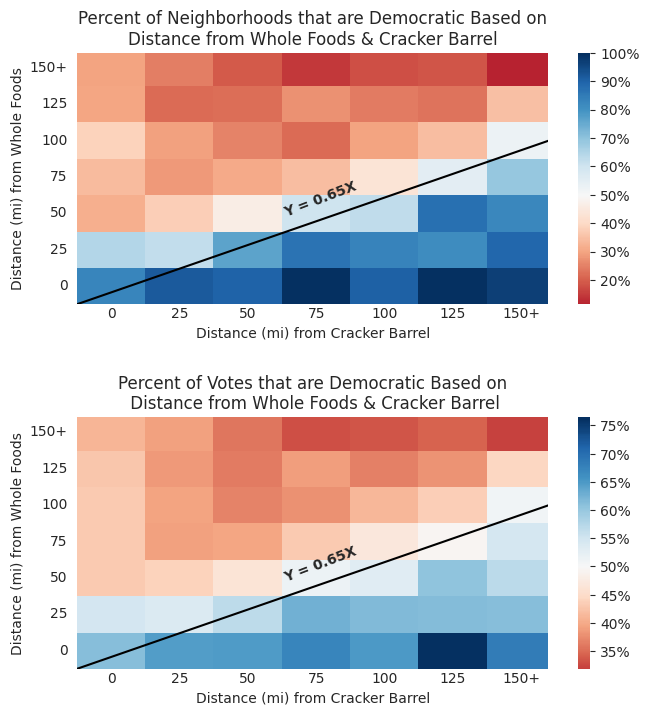

In [ ]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_style('darkgrid')


plt.clf()
fig, axes = plt.subplots(2,1, figsize=(1.9*4,1*4*2))
fig.subplots_adjust(hspace=0.45)
g = sns.heatmap(
    vote_heatmap,
    cmap ='RdBu',
    vmin=vote_min,
    center=0.5,
    vmax=vote_max,
    # cbar_kws={'label': '% Neighborhoods w/ Democratic Majority'},
    ax = axes[0]
)

g = sns.heatmap(
    lean_heatmap,
    cmap ='RdBu',
    vmin=lean_min,
    center=0.5,
    vmax=lean_max,
    # cbar_kws={'label': '% Neighborhoods w/ Democratic Majority'},
    ax = axes[1]
)

axes[0].set(
    xlabel = 'Distance (mi) from Cracker Barrel',
    ylabel = "Distance (mi) from Whole Foods",
    title='Percent of Neighborhoods that are Democratic Based on\nDistance from Whole Foods & Cracker Barrel'
)
axes[1].set(
    xlabel = 'Distance (mi) from Cracker Barrel',
    ylabel = "Distance (mi) from Whole Foods",
    title='Percent of Votes that are Democratic Based on\n Distance from Whole Foods & Cracker Barrel'
)


axes[0].invert_yaxis()
axes[1].invert_yaxis()


axes[0].set_yticklabels(
    [i.get_text()+"+" if "150" in i.get_text() else i.get_text() for i in axes[0].get_yticklabels()],
     va='center',
     rotation=0
)
axes[1].set_yticklabels(
    [i.get_text()+"+" if "150" in i.get_text() else i.get_text() for i in axes[1].get_yticklabels()],
     va='center',
     rotation=0
)

axes[0].set_xticklabels(
    [i.get_text()+"+" if "150" in i.get_text() else i.get_text() for i in axes[1].get_xticklabels()],
     va='center',
     rotation=0
)
axes[1].set_xticklabels(
    [i.get_text()+"+" if "150" in i.get_text() else i.get_text() for i in axes[1].get_xticklabels()],
     va='center',
     rotation=0
)

cbar = axes[0].collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))


cbar = axes[1].collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))

axes[0].set(xlim=(0,6.9),ylim=(0,6.9))
axes[1].set(xlim=(0,6.9),ylim=(0,6.9))

x = np.linspace(0,6.9,100)
y = .65*x

axes[1].plot(x, y, color='black')
axes[1].text(
    3,
    2.4,
    rotation = 21,
    s= "Y = 0.65X",
    weight="bold"
)

axes[0].plot(x, y, color='black')
axes[0].text(
    3,
    2.4,
    rotation = 21,
    s= "Y = 0.65X",
    weight="bold"
)


fig = g.get_figure()
fig.savefig('heatmap.png', dpi=300, bbox_inches="tight")

# Modeling

## LR

In [ ]:
h3 = h3_lean.toPandas()

In [ ]:
h3_pd = h3[h3['dem_pct'].notnull()]

In [ ]:
h3_pd['wf'] = h3_pd['wf']
h3_pd['cb'] = h3_pd['cb']
max_dist_new = max_dist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
h3_pd['wf']

0               NaN
1               NaN
2               NaN
3        110.663124
4         47.291164
            ...    
30611     92.954002
30612           NaN
30613           NaN
30614    115.878548
30615     62.357048
Name: wf, Length: 30044, dtype: float32

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [ ]:
X = h3_pd.iloc[:, 1:-1].fillna(max_dist_new)
y = round(h3_pd.iloc[:,-1], 0)

In [ ]:
y.mean()

0.27123552123552125

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [ ]:
metrics.balanced_accuracy_score(y_test, y_pred)

0.6353666137580004

In [ ]:
metrics.roc_auc_score(y_test, y_pred_proba)

0.7319016054187478

In [ ]:
y_pred

array([0., 0., 1., ..., 0., 0., 0.])

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb= XGBClassifier()

In [ ]:
xgb_model = xgb.fit(X_train, y_train)

In [ ]:
xgb_pred = xgb_model.predict(X_test)

In [ ]:
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
balanced_accuracy_score(y_test, xgb_pred)

0.6301883114145467

In [ ]:
metrics.roc_auc_score(y_test, xgb_pred_proba)

0.7530790388764232

# Heuristics

In [ ]:
dist_list = [20 ,40, 60, 80, 100, 120, 140, max_dist]

In [ ]:
accuracy_list = []
for dist in dist_list:
    X_train['predict'] = np.where(
        X_train['wf'] <= dist,
        1,
        0
    )
    accuracy_list.append(
        balanced_accuracy_score(y_train, X_train['predict'])
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
accuracy_list

[0.547068499093871,
 0.6008991848634939,
 0.6380970149931814,
 0.6582265810283296,
 0.671602362111715,
 0.6711170225226197,
 0.6653683575939027,
 0.5]

In [ ]:
X_test['predict'] = np.where(
    X_test['wf'] <= 100,
    1,
    0
)
balanced_accuracy_score(y_test, X_test['predict'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0.6716726869567586

In [ ]:
metrics.roc_auc_score(y_test, X_test['predict'])

0.6716726869567586